### 4. Wrangling Data

#### B. Preparing the prediction data

On this step we will kringe the weather data to each square on the map.

This is important as it will guarantee that we have a balanced approach on the prediction data. To ensure we are balancing the data both geographically and temporally we will use KNN basing the centroids form the binned map and the weather stations that we have information for.

`This notebook may be expanded in the future.`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box, Point, LineString, Polygon

%matplotlib inline

In [6]:
# Importing data
nsw = gpd.read_file('./data/processed/map/binned_nsw.shp')
nsw.head()

,longitude,latitude,geometry
0,141.499925,-29.499478,"POLYGON ((141.00000 -30.00000, 141.00000 -30.0..."
1,141.500269,-30.499963,"POLYGON ((141.00000 -30.00000, 142.00000 -30.0..."
2,141.500470,-31.499924,"POLYGON ((141.00062 -31.00000, 142.00000 -31.0..."
3,141.500876,-32.499934,"POLYGON ((141.00136 -32.00000, 142.00000 -32.0..."
4,141.506408,-33.558650,"POLYGON ((142.00000 -34.00000, 142.00000 -34.1..."


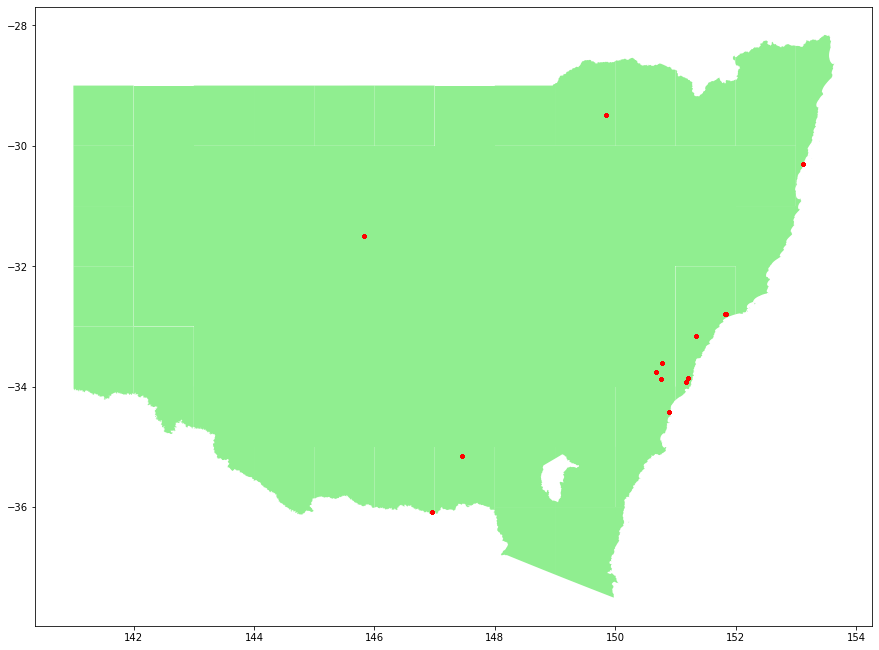

In [169]:
# Plotting to map to guarantee data robustness.
weather = gpd.read_file('./data/processed/weather/clean_weather.shp')

# Creating figure to plot
fig, ax = plt.subplots(figsize=(15,15))
# Plot the country borders
nsw.plot(ax=ax, color='LightGreen')
# Plot the individual points
weather['geometry'].plot(ax=ax, color='red',  markersize=10)

In [25]:
# Creating the location column
nsw.reset_index(inplace=True)
nsw.rename(columns={'index':'location'}, inplace = True)

In [98]:
# adding the date to all locations
names = ['nsw_'+str(x) for i in range(len(nsw))]
for x in range(len(nsw)): 
    # Appending the dates to the locations
    names[x] = nsw[nsw['location'] == x].drop('geometry', axis=1).join(weather[weather['location']=='Albury'].date, how='outer')
    print()
    # Inputing the latitude    
    names[x].latitude = nsw.loc[x].latitude
    # Inputing the longitude    
    names[x].longitude = nsw.loc[x].longitude
    # Inputing the location    
    names[x].location = nsw.loc[x].location
grid = pd.concat(names)

In [109]:
# making the null columns for imputation with Knn
col = ['mintemp', 'maxtemp', 'rainfall', 'evaporatio',
       'sunshine', 'windgustsp', 'windspeed9', 'windspeed3', 'humidity9a', 'humidity3p', 'pressure9a',
       'pressure3p', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm']

for columns in col:
    grid[columns] = None

In [177]:
# Dropping columns that will not work with the imputation
weather.drop(['windgustdi','winddir9am', 'winddir3pm', 'geometry','raintoday',
       'risk_mm', 'raintomorr',], axis=1, inplace=True)
# Creating a datetime colum to assist on the imputation
weather['datetime'] = pd.to_datetime(weather['date'])
grid['datetime'] = pd.to_datetime(grid['date'])


In [222]:
# Getting the day, month and year columns for the knn imputation
# Weather DF
weather['year'] = weather['datetime'].dt.year
weather['month'] = weather['datetime'].dt.month
weather['day'] = weather['datetime'].dt.day
# Grid DF
grid['year'] = grid['datetime'].dt.year
grid['month'] = grid['datetime'].dt.month
grid['day'] = grid['datetime'].dt.day


In [234]:
# Creating a function for imutation
from sklearn import neighbors

def imputator(X_train, y_train, X_predict):
    # Getting the desired imputation column
    y_train = y_train
    # getting the predictions
    return neighbors.KNeighborsRegressor(n_neighbors=2).fit(X_train,y_train).predict(X_predict)

In [236]:
%%time
# Applying function to the whole DF
# Preparing the predictor features, location and time
X_weather = weather.dropna()[['latitude','longitude','year', 'month', 'day']]

X_grid = grid[['latitude','longitude','year', 'month', 'day']]
# Preparing th loop that will run through the features
for column in ['mintemp', 'maxtemp', 'rainfall', 'evaporatio',
       'sunshine', 'windgustsp', 'windspeed9', 'windspeed3', 'humidity9a',
       'humidity3p', 'pressure9a', 'pressure3p', 'cloud9am', 'cloud3pm',
       'temp9am', 'temp3pm']:
    # 
    y_weather = weather.dropna()[[column]]
    # Applying function
    grid[column] = imputator(X_train=X_weather, y_train=y_weather, X_predict=X_grid)
    

Wall time: 44.7 s


The kringing process above could run faster, but is effective and the step-by-step break will help if I want to change any part of it in the future.

I need to be a little pedantic here and check that what was done was effective and makes sense. Let's check the values that we got and make sure that they are distinct for each location.

In [238]:
# Checking the final DS
grid.describe().T

,count,mean,std,min,25%,50%,75%,max
location,222814.0,36.500000,21.360057,0.000000,18.00,36.500000,55.00,73.000000
longitude,222814.0,146.928739,3.156303,141.499925,144.50,146.999929,149.50,153.229801
latitude,222814.0,-32.190937,2.037310,-36.634534,-33.50,-32.098032,-30.50,-29.118454
mintemp,222814.0,12.352538,6.256905,-2.750000,7.30,12.450000,17.60,29.000000
maxtemp,222814.0,24.933506,7.116428,8.200000,19.20,24.850000,30.30,46.100000
rainfall,222814.0,1.768986,4.587640,0.000000,0.00,0.000000,1.00,84.900000
evaporatio,222814.0,6.367734,4.867398,0.000000,2.80,5.300000,8.80,54.800000
sunshine,222814.0,8.354282,3.135251,0.000000,6.20,8.850000,10.75,13.850000
windgustsp,222814.0,38.181862,10.371019,13.000000,30.50,37.000000,44.50,99.500000
windspeed9,222814.0,14.714470,5.955079,0.000000,10.50,14.000000,18.50,60.500000


In [260]:
for i in range(len(nsw)):
    print(grid[grid.location == i].mintemp.max())

28.0
28.0
29.0
29.0
29.0
28.0
28.0
29.0
29.0
29.0
28.0
28.0
29.0
29.0
29.0
27.65
28.0
28.0
29.0
29.0
29.0
27.25
27.25
28.0
28.0
29.0
29.0
29.0
27.25
27.25
28.0
28.0
29.0
29.0
27.65
27.25
27.25
27.450000000000003
28.0
29.0
29.0
27.25
25.5
25.5
27.450000000000003
27.450000000000003
27.450000000000003
27.65
25.5
25.5
25.5
25.5
27.450000000000003
27.450000000000003
27.450000000000003
27.3
27.3
27.3
27.3
25.5
27.450000000000003
27.450000000000003
26.25
27.3
27.3
27.3
27.450000000000003
24.15
26.25
26.25
24.15
24.15
25.6
24.15


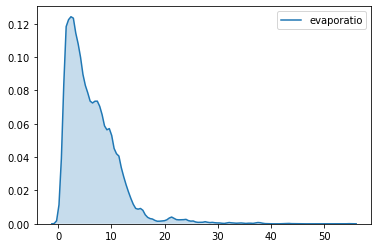

In [273]:
sns.kdeplot(grid.evaporatio, shade=1)
# grid.evaporatio.hist(grid=False, bins=73)

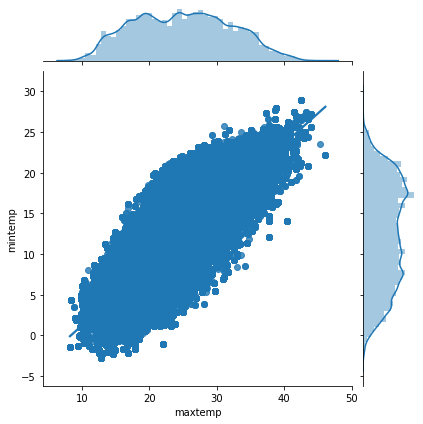

In [272]:
sns.jointplot(y=grid.mintemp,x=grid.maxtemp, data=grid, kind='reg')

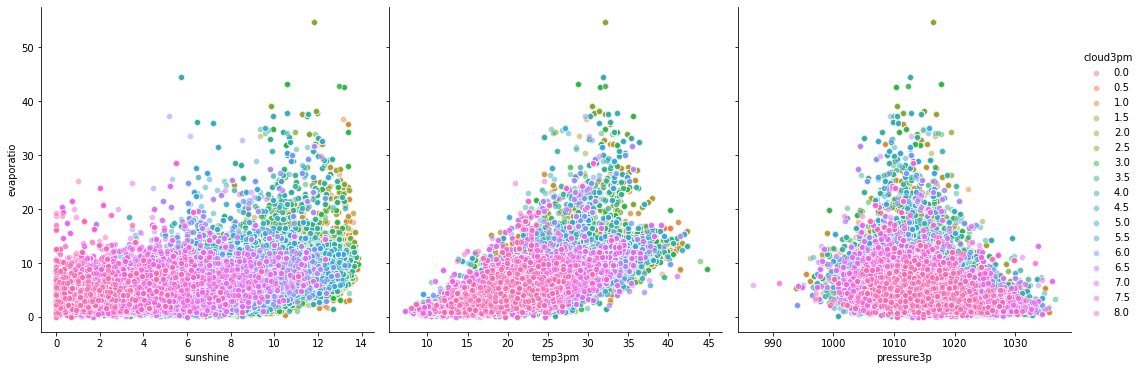

In [280]:
# sns.jointplot(y=grid.evaporatio,x=grid.sunshine, data=grid, kind='reg')

sns.pairplot(grid, x_vars=["sunshine", "temp3pm", "pressure3p"], y_vars=["evaporatio"],
             hue="cloud3pm", height=5, aspect=1, kind="scatter", plot_kws={'alpha':0.5})

They could be better distributed, but they make sense with what we had on the weather dataset.

If we want better information we need to procure data from more weather stations across NSW.

Finally lets check that the information we have is compatible with the centroids.

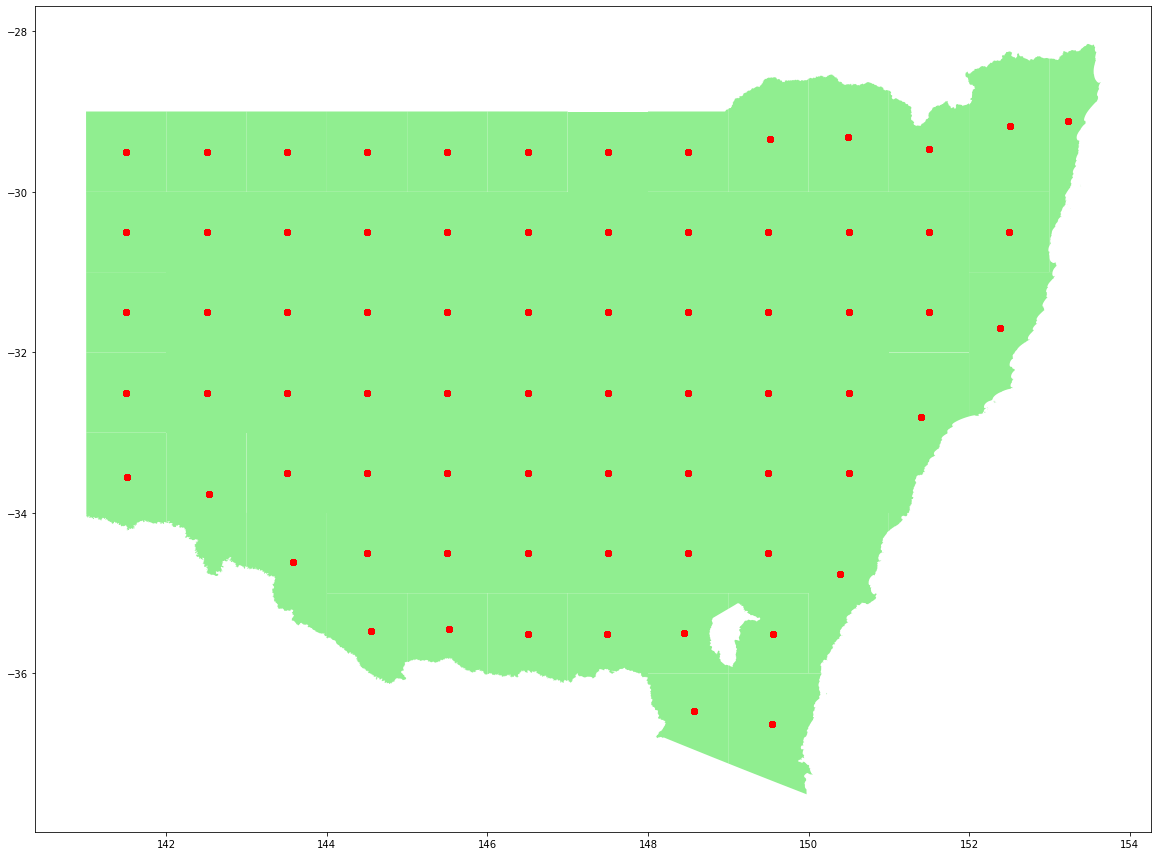

In [307]:
# Double checking that the latitude and longitude are cmpatible with the centroids
# Creating figure to plot
fig, ax = plt.subplots(figsize=(20,20))
# Plot the country borders
nsw.plot(ax=ax, color='LightGreen')
# Plot the individual points
ax.scatter([grid[grid.location == x].longitude for x in range(len(nsw)) ], [grid[grid.location == x].latitude for x in range(len(nsw)) ], color='red')

The weahter information is looking good.

The centroids here are only a representation of the squares. in reality we are considering that all points in a given square are under the same weather condition as the centroid. Again, more granularity would be ideal, but computationally expensive.